The goal of this notebook is to learn to use Neural Networks for text classification. The main goal is to understand how we can apply deep learning on raw text and what are the techniques behind it

In this notebook I will train a shallow model with learning embeddings

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re,string,unicodedata
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize

from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Flatten,MaxPooling1D
from keras import callbacks
from keras.models import Sequential,Model
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU,Conv1D,MaxPooling1D,Input,GlobalAveragePooling1D
import tensorflow as tf
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_auc_score,f1_score
from sklearn.model_selection import train_test_split
import gensim.models
from tensorflow.keras.utils import plot_model

In [2]:
# read the dataset of csv extension to dataframe
df = pd.read_csv("product_reviews.csv")

In [3]:
# Understanding the dataset
df.head(5)

,reviews.rating,reviews.text
0,1,I read through the reviews on here before look...
1,1,My husband bought this gel for us. The gel cau...
2,1,My boyfriend and I bought this to spice things...
3,1,Bought this earlier today and was excited to c...
4,1,I bought this product for my husband and I to ...


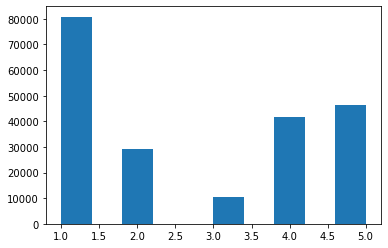

In [4]:
# Visualizing the data distribution according to rating
plt.hist(df['reviews.rating'])
plt.show()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208434 entries, 0 to 208433
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   reviews.rating  208434 non-null  int64 
 1   reviews.text    208361 non-null  object
dtypes: int64(1), object(1)
memory usage: 3.2+ MB


In [6]:
df.describe()

,reviews.rating
count,208434.000000
mean,2.731584
std,1.646777
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,5.000000


In [7]:
# Adding a 'target' column such that rating : 4,5 is assigned to 0 and rating : 1,2,3 is assigned to 1
df['target'] = [1 if i<4 else 0 for i in df['reviews.rating']] 

In [8]:
df.head(5)

,reviews.rating,reviews.text,target
0,1,I read through the reviews on here before look...,1
1,1,My husband bought this gel for us. The gel cau...,1
2,1,My boyfriend and I bought this to spice things...,1
3,1,Bought this earlier today and was excited to c...,1
4,1,I bought this product for my husband and I to ...,1


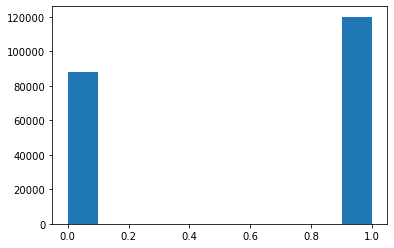

In [9]:
plt.hist(df['target'])
plt.show()

In [10]:
# finding number of Nan values
df.isna().sum()

reviews.rating     0
reviews.text      73
target             0
dtype: int64

In [11]:
# Dropping rows with Nan values
df = df.dropna(axis=0)
df.isna().sum()

reviews.rating    0
reviews.text      0
target            0
dtype: int64

In [12]:
# Splitting data to features and labels
x = df['reviews.text']
y = df['target']

### Cleaning the texts. 

In [13]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

#Removing the stopwords from text
def split_into_words(text):
    # split into words by white space
    words = text.split()
    return words

def to_lower_case(words):
    # convert to lower case
    words = [word.lower() for word in words]
    return words

def remove_punctuation(words):
    # prepare regex for char filtering
    # string.punctuation will return '!"#$%&'()*+, -./:;<=>?@[\]^_`{|}~'
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # re.escape() will return pattern object '\d\$' if input is 'd$'
    # remove punctuation from each word
    stripped = [re_punc.sub('', w) for w in words]
    return stripped

def keep_alphabetic(words):
    # remove remaining tokens that are not alphabetic
    words = [word for word in words if word.isalpha()]
    return words

def remove_stopwords(words):
    # filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    return words

def to_sentence(words):
    # join words to a sentence
    return ' '.join(words)

#Removing the noisy text
def denoise_text(text):
    words = split_into_words(text)
    words = to_lower_case(words)
    words = remove_punctuation(words)
    words = keep_alphabetic(words)
    words = remove_stopwords(words)
    return to_sentence(words)

In [14]:
# Apply functions to clean sentences.
x = x.apply(denoise_text)

In [15]:
docs = x.values
window_as_median_sentence_length = np.median([len(s.split()) for s in docs]).astype(int)
print(window_as_median_sentence_length)

13


In [16]:
# splitting data for training and testing purposes.
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2,random_state=123)

### Preprocessing text for the (supervised) CBOW model

We will implement a simple classification model in Keras. Raw text requires (sometimes a lot of) preprocessing.

The following cells uses Keras to preprocess text:
- using a tokenizer. You may use different tokenizers (from scikit-learn, NLTK, custom Python function etc.). This converts the texts into sequences of indices representing the `40000` most frequent words
- sequences have different lengths, so we pad them (add 0s at the end until the sequence is of length `50`)
- we convert the output classes as 1-hot encodings

https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

In [17]:
MAX_NB_WORDS = 40000

new_x_train = x_train.astype(str)
new_x_test = x_test.astype(str)

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, char_level=False)

# 'fit_on_texts' Updates internal vocabulary using 'new_x_train'
tokenizer.fit_on_texts(new_x_train) 

# 'texts_to_sequences' transforms each text in 'new_x_train' to a sequence of integers(vector).
sequences = tokenizer.texts_to_sequences(new_x_train)

# 'texts_to_sequences' transforms each text in 'new_x_test' to a sequence of integers(vector).
sequences_test = tokenizer.texts_to_sequences(new_x_test)

word_index = tokenizer.word_index
# 'word_index' is a dictionary of the form,  {'the': 1, 'i': 2, 'and': 3, etc...}
print('Found %s unique tokens.' % len(word_index))

Found 69487 unique tokens.


In [18]:
max_length = np.max([len(s.split()) for s in docs])
print('Maximum length: %d' % max_length)

Maximum length: 2301


The tokenizer object stores a mapping (vocabulary) from word strings to token ids that can be inverted to reconstruct the original message (without formatting)

In [19]:
type(tokenizer.word_index), len(tokenizer.word_index)

(dict, 69487)

In [20]:
index_to_word = dict((i, w) for w, i in tokenizer.word_index.items())
# changing dict from {'the': 1, 'i': 2} form to {1 :'the', 2 :'i'} form , then can access 
# a word by 'index_to_word[i]' where i is 1,2,3,...,len(word_index)

In [21]:
sequences[3]

[17, 169, 55, 169, 4, 323]

In [22]:
# we can re create 'ith' sentence by joing words from 'index_to_word' at 
# indexes taken from 'sequences[i]''

" ".join([index_to_word[i] for i in sequences[3]])

'movie wasnt bad wasnt good either'

Let's have a closer look at the tokenized sequences

In [23]:
seq_lens = [len(s) for s in sequences]
#seq_lens is a list holds length of every sentence.

print("Average length of sentences : %0.1f" % np.mean(seq_lens))
print("Length of large sentence : {}".format(max(seq_lens)))

Average length of sentences : 22.4
Length of large sentence : 1591


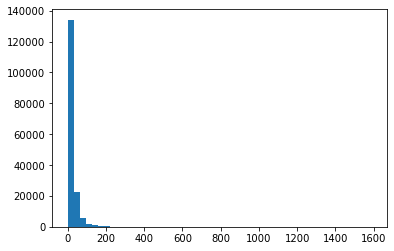

In [24]:
plt.hist(seq_lens, bins=50) #'range=(min(seq_lens),max(seq_lens))' can also used to specify range
plt.show()


Let's zoom on the distribution of regular sized posts. The vast majority of the posts have less than 200 symbols:

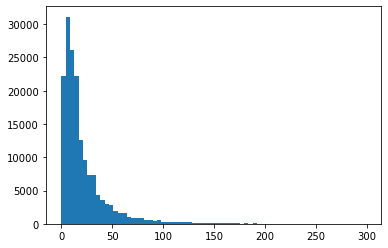

In [25]:
plt.hist([l for l in seq_lens if l < 300], bins=70);

Setting the length of every sequence to '50' sequence with length less than '50' will padded with zeros at the beginning of sequence or the vectorized text

In [26]:
MAX_SEQUENCE_LENGTH = 50

# pad sequences with 0s
x_train = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor :', x_train.shape)
print('Shape of data test tensor :', x_test.shape)

Shape of data tensor : (166688, 50)
Shape of data test tensor : (41673, 50)


### Using callbacks.EarlyStopping method to set conditions for early stopping to reduce overfitting

In [27]:
# Defining function for early stopping
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 3, 
                                        restore_best_weights = True, verbose=1, )
#setting size for embedding vector
EMBEDDING_DIM = 100
N_CLASSES = 1

# A simple supervised CBOW model in Keras

Vector space model is well known in information retrieval where each document is represented as a vector. The vector components represent weights or importance of each word in the document. The similarity between two documents is computed using the cosine similarity measure.

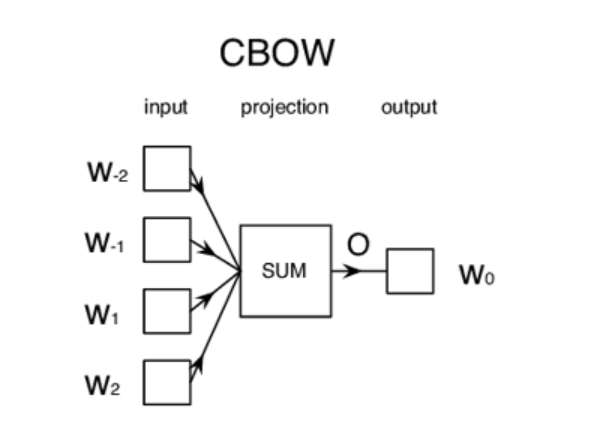

CBOW References :
i) https://iksinc.online/tag/continuous-bag-of-words-cbow/
ii) https://analyticsindiamag.com/the-continuous-bag-of-words-cbow-model-in-nlp-hands-on-implementation-with-codes/



In [28]:
EMBEDDING_DIM = 100
N_CLASSES = 1

# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

# 2nd layer
embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
# Linking input to 2nd layer
embedded_sequences = embedding_layer(sequence_input)

average = GlobalAveragePooling1D()(embedded_sequences)
predictions = Dense(N_CLASSES, activation='sigmoid')(average)

model = Model(sequence_input, predictions)
model.compile(loss='binary_crossentropy',\
              optimizer='adam', metrics=['acc'])

In [29]:
model.summary() #to view the model details

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 100)           4000000   
                                                                 
 global_average_pooling1d (G  (None, 100)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 4,000,101
Trainable params: 4,000,101
Non-trainable params: 0
_________________________________________________________________


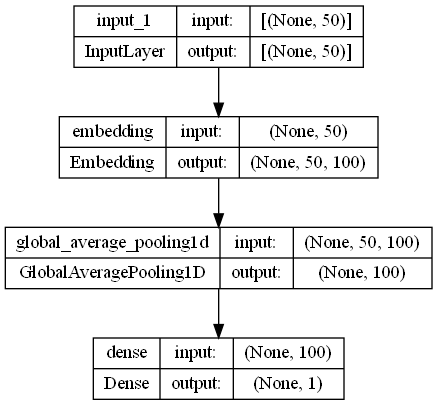

In [30]:
#to plot the model
tf.keras.utils.plot_model(model, "cbow.png", show_shapes=True)

In [31]:
reg_history = model.fit(x_train, y_train, validation_split=0.1,epochs =20,\
                        batch_size=128, callbacks =[earlystopping], verbose=1)

Epoch 1/20
1173/1173 [==============================] - 68s 57ms/step - loss: 0.4144 - acc: 0.8307 - val_loss: 0.3100 - val_acc: 0.8864
Epoch 2/20
1173/1173 [==============================] - 66s 56ms/step - loss: 0.2866 - acc: 0.8922 - val_loss: 0.2805 - val_acc: 0.8967
Epoch 3/20
1173/1173 [==============================] - 68s 58ms/step - loss: 0.2574 - acc: 0.9047 - val_loss: 0.2708 - val_acc: 0.9009
Epoch 4/20
1173/1173 [==============================] - 66s 56ms/step - loss: 0.2388 - acc: 0.9122 - val_loss: 0.2669 - val_acc: 0.8998
Epoch 5/20
1173/1173 [==============================] - 65s 56ms/step - loss: 0.2248 - acc: 0.9178 - val_loss: 0.2604 - val_acc: 0.9048
Epoch 6/20
1173/1173 [==============================] - 67s 57ms/step - loss: 0.2136 - acc: 0.9221 - val_loss: 0.2593 - val_acc: 0.9078
Epoch 7/20
1173/1173 [==============================] - 66s 57ms/step - loss: 0.2043 - acc: 0.9258 - val_loss: 0.2580 - val_acc: 0.9079
Epoch 8/20
1173/1173 [==========================

In [32]:
#saving the model
model.save('cbow1')

INFO:tensorflow:Assets written to: cbow1\assets


In [33]:
# Loading the model from saved location
model = keras.models.load_model('cbow1')

In [34]:
print("Train accuracy is :",reg_history.history['acc'][-1])
print("Train loss is :",reg_history.history['loss'][-1])
print("validation accuracy is :",reg_history.history['val_acc'][-1])
print("Validation loss  is :",reg_history.history['val_loss'][-1])

Train accuracy is : 0.9326218962669373
Train loss is : 0.18494664132595062
validation accuracy is : 0.9082728624343872
Validation loss  is : 0.2666715085506439


In [35]:
output_test = model.predict(x_test, verbose=1)

# ROC_AUC: the Area Under the Curve (AUC) of the Receiver Operating Characteristic (ROC) curve
print("test auc:", roc_auc_score(y_test,output_test))

1303/1303 [==============================] - 2s 1ms/step
test auc: 0.9581853147403412


In [36]:
test_scores = model.evaluate(x_test, y_test, verbose=1)
print("\nTest loss :", test_scores[0])
print("Test accuracy :", test_scores[1])

1303/1303 [==============================] - 2s 2ms/step - loss: 0.2705 - acc: 0.9028

Test loss : 0.2704954445362091
Test accuracy : 0.902766764163971


In [37]:
# Confusion Matrix for test
p_test = [1 if i>.5 else 0 for i in output_test[:]]
cm_test = confusion_matrix(y_test,p_test)
cm_test

array([[15589,  2113],
       [ 1939, 22032]], dtype=int64)

Text(33.0, 0.5, 'Actual')

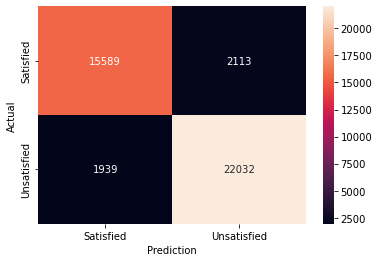

In [38]:
# Visualising Confusion matrix using heatmap form seaborn
ax = sns.heatmap(cm_test,annot=True,xticklabels=['Satisfied','Unsatisfied'],yticklabels=['Satisfied','Unsatisfied'],fmt='g')
ax.set_xlabel('Prediction')
ax.set_ylabel('Actual')

In [39]:
# F1 score

print("Test F1 score is : ", f1_score(y_test,p_test))

Test F1 score is :  0.9157868484495802


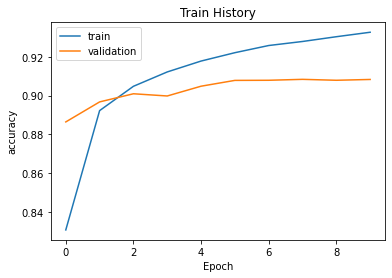

In [40]:
plt.plot(reg_history.history['acc'])
plt.plot(reg_history.history['val_acc'])
plt.title('Train History')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# A complex model : LSTM

![](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png)

image taken from : http://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [41]:
# Using Functional API
# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences = embedding_layer(sequence_input)

x = LSTM(64, dropout=0.2, recurrent_dropout=0.2)(embedded_sequences)

predictions = Dense(1, activation='sigmoid')(x)

model = Model(sequence_input, predictions)       # previos 96 and 92 acc    and f1 : 93
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [42]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 50, 100)           4000000   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,042,305
Trainable params: 4,042,305
Non-trainable params: 0
_________________________________________________________________


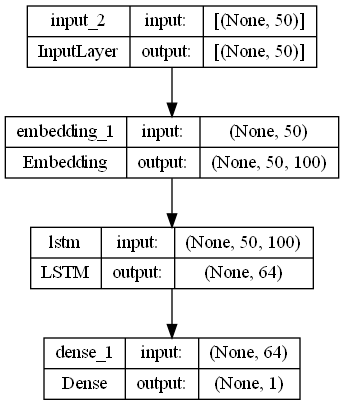

In [43]:
#to plot the model
tf.keras.utils.plot_model(model, "LSTM.png", show_shapes=True)

In [44]:
reg_history = model.fit(x_train, y_train, validation_split=0.1,epochs=10, batch_size=128, callbacks =[earlystopping], verbose=1)

Epoch 1/10
1173/1173 [==============================] - 200s 166ms/step - loss: 0.2889 - acc: 0.8811 - val_loss: 0.2309 - val_acc: 0.9095
Epoch 2/10
1173/1173 [==============================] - 182s 155ms/step - loss: 0.1976 - acc: 0.9231 - val_loss: 0.2120 - val_acc: 0.9218
Epoch 3/10
1173/1173 [==============================] - 186s 159ms/step - loss: 0.1564 - acc: 0.9409 - val_loss: 0.2042 - val_acc: 0.9239
Epoch 4/10
1173/1173 [==============================] - 191s 163ms/step - loss: 0.1305 - acc: 0.9509 - val_loss: 0.2104 - val_acc: 0.9241
Epoch 5/10
1173/1173 [==============================] - 189s 161ms/step - loss: 0.1116 - acc: 0.9582 - val_loss: 0.2139 - val_acc: 0.9326
Epoch 6/10
1173/1173 [==============================] - 182s 155ms/step - loss: 0.0970 - acc: 0.9640 - val_loss: 0.2164 - val_acc: 0.9326
Epoch 6: early stopping


In [45]:
#saving the model
model.save('lstm1')

INFO:tensorflow:Assets written to: lstm1\assets


In [46]:
# Loading the model from saved location
model = keras.models.load_model('lstm1')

In [47]:
output_test = model.predict(x_test)
print("test auc:", roc_auc_score(y_test,output_test[:]))

1303/1303 [==============================] - 12s 9ms/step
test auc: 0.9720282865804767


In [48]:
test_scores = model.evaluate(x_test, y_test, verbose=1)
print("\nTest loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

1303/1303 [==============================] - 12s 9ms/step - loss: 0.2119 - acc: 0.9198

Test loss: 0.21185317635536194
Test accuracy: 0.9197561740875244


In [49]:
print("Train accuracy is :",reg_history.history['acc'][-1])
print("Train loss is :",reg_history.history['loss'][-1])
print("validation accuracy is :",reg_history.history['val_acc'][-1])
print("Validation loss  is :",reg_history.history['val_loss'][-1])

Train accuracy is : 0.9639512300491333
Train loss is : 0.09700712561607361
validation accuracy is : 0.932629406452179
Validation loss  is : 0.21643786132335663


In [50]:
# Confusion Matrix for test
p_test = [1 if i>.5 else 0 for i in output_test[:]]
cm_test = confusion_matrix(y_test,p_test)
cm_test

array([[16202,  1500],
       [ 1844, 22127]], dtype=int64)

Text(33.0, 0.5, 'Actual')

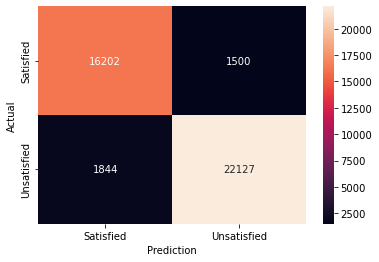

In [51]:
# Visualising Confusion matrix using heatmap form seaborn
ax = sns.heatmap(cm_test,annot=True,xticklabels=['Satisfied','Unsatisfied'],yticklabels=['Satisfied','Unsatisfied'],fmt='g')
ax.set_xlabel('Prediction')
ax.set_ylabel('Actual')

In [52]:
p_test = [1 if i>.5 else 0 for i in output_test[:]]
print("Test F1 score is : ", f1_score(y_test,p_test))

Test F1 score is :  0.9297449472666918


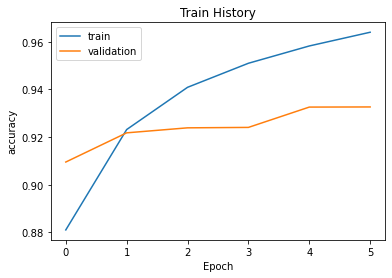

In [54]:
plt.plot(reg_history.history['acc'])
plt.plot(reg_history.history['val_acc'])
plt.title('Train History')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## A more complex model : CNN - LSTM

In [55]:
# Using Functional API
# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
embedded_sequences = embedding_layer(sequence_input)

# 1D convolution with 50 output channels
x = Conv1D(50, 5)(embedded_sequences)
x = Dropout(0.2)(x)
# LSTM layer with a hidden size of 64
x = LSTM(50, dropout=0.2, recurrent_dropout=0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(sequence_input, predictions)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [56]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_2 (Embedding)     (None, 50, 100)           4000000   
                                                                 
 conv1d (Conv1D)             (None, 46, 50)            25050     
                                                                 
 dropout (Dropout)           (None, 46, 50)            0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 4,045,301
Trainable params: 4,045,301
Non-tra

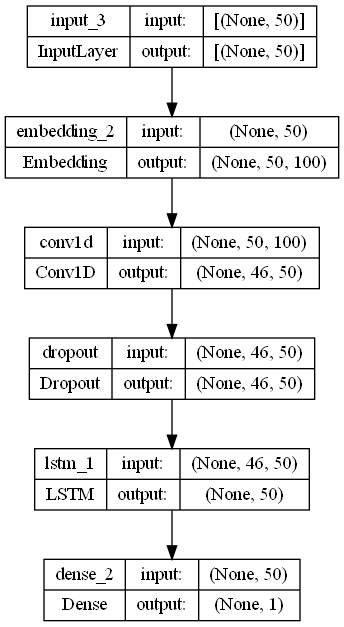

In [57]:
#to plot the model
tf.keras.utils.plot_model(model, "cnn_lstm.png", show_shapes=True)

In [58]:
reg_history = model.fit(x_train, y_train, validation_split=0.1,epochs=10, batch_size=128, callbacks =[earlystopping], verbose=1)

Epoch 1/10
1173/1173 [==============================] - 167s 138ms/step - loss: 0.2833 - acc: 0.8831 - val_loss: 0.2224 - val_acc: 0.9143
Epoch 2/10
1173/1173 [==============================] - 160s 137ms/step - loss: 0.1834 - acc: 0.9309 - val_loss: 0.2076 - val_acc: 0.9189
Epoch 3/10
1173/1173 [==============================] - 160s 136ms/step - loss: 0.1376 - acc: 0.9497 - val_loss: 0.2047 - val_acc: 0.9296
Epoch 4/10
1173/1173 [==============================] - 160s 136ms/step - loss: 0.1034 - acc: 0.9627 - val_loss: 0.2157 - val_acc: 0.9315
Epoch 5/10
1173/1173 [==============================] - 154s 131ms/step - loss: 0.0838 - acc: 0.9698 - val_loss: 0.2266 - val_acc: 0.9350
Epoch 6/10
1173/1173 [==============================] - 155s 132ms/step - loss: 0.0707 - acc: 0.9746 - val_loss: 0.2294 - val_acc: 0.9369
Epoch 6: early stopping


In [59]:
#saving the model
model.save('cnn_lstm')

INFO:tensorflow:Assets written to: cnn_lstm\assets


INFO:tensorflow:Assets written to: cnn_lstm\assets


In [60]:
# Loading the model from saved location
model = keras.models.load_model('cnn_lstm')

In [61]:
output_test = model.predict(x_test)
print("test auc:", roc_auc_score(y_test,output_test[:]))

1303/1303 [==============================] - 13s 10ms/step
test auc: 0.9732230476247565


In [62]:
test_scores = model.evaluate(x_test, y_test, verbose=1)
print("\nTest loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

1303/1303 [==============================] - 13s 9ms/step - loss: 0.2130 - acc: 0.9256

Test loss: 0.21299588680267334
Test accuracy: 0.9255872964859009


In [63]:
print("Train accuracy is :",reg_history.history['acc'][-1])
print("Train loss is :",reg_history.history['loss'][-1])
print("validation accuracy is :",reg_history.history['val_acc'][-1])
print("Validation loss  is :",reg_history.history['val_loss'][-1])

Train accuracy is : 0.9745965600013733
Train loss is : 0.07072517275810242
validation accuracy is : 0.9368888139724731
Validation loss  is : 0.2293844372034073


In [64]:
# Confusion Matrix for test
p_test = [1 if i>.5 else 0 for i in output_test[:]]
cm_test = confusion_matrix(y_test,p_test)
cm_test

array([[16292,  1410],
       [ 1691, 22280]], dtype=int64)

Text(33.0, 0.5, 'Actual')

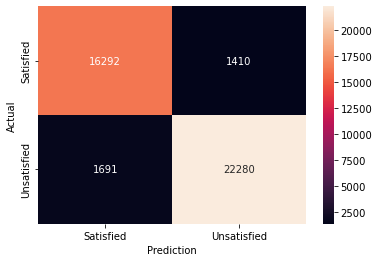

In [65]:
# Visualising Confusion matrix using heatmap form seaborn
ax = sns.heatmap(cm_test,annot=True,xticklabels=['Satisfied','Unsatisfied'],yticklabels=['Satisfied','Unsatisfied'],fmt='g')
ax.set_xlabel('Prediction')
ax.set_ylabel('Actual')

In [66]:
p_test = [1 if i>.5 else 0 for i in output_test[:]]
print("Test F1 score is : ", f1_score(y_test,p_test))

Test F1 score is :  0.9349363211011098


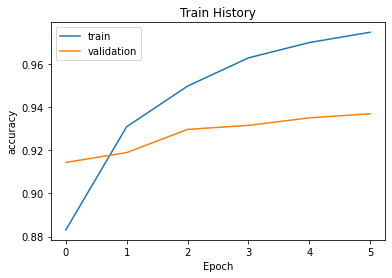

In [68]:
plt.plot(reg_history.history['acc'])
plt.plot(reg_history.history['val_acc'])
plt.title('Train History')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Applying Word2Vec on CNN - LSTM Network

In [69]:
W2V_GoogleNews = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',\
                                                                 binary=True)

In [70]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((MAX_NB_WORDS, 300))
for word, i in word_index.items():
    try:
        # update embedding matrix using Google's pretrained model
        embedding_vector = W2V_GoogleNews.get_vector(word, norm=True)
        embedding_matrix[i] = embedding_vector
    except:
        # when word isn't found in pretrained model, we keep the embedding matrix unchanged at that index (assigned to zero)
        pass

In [71]:
# Using Functional API
# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedding_layer = Embedding(MAX_NB_WORDS, output_dim=300,\
                            input_length=MAX_SEQUENCE_LENGTH,\
                            trainable=True, weights=[embedding_matrix])
embedded_sequences = embedding_layer(sequence_input)

# 1D convolution with 50 output channels
x = Conv1D(50, 5)(embedded_sequences)
x = Dropout(0.2)(x)
# 50 LSTM units
x = LSTM(50, dropout=0.2, recurrent_dropout=0.2)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(sequence_input, predictions)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [72]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding_3 (Embedding)     (None, 50, 300)           12000000  
                                                                 
 conv1d_1 (Conv1D)           (None, 46, 50)            75050     
                                                                 
 dropout_1 (Dropout)         (None, 46, 50)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 12,095,301
Trainable params: 12,095,301
Non-t

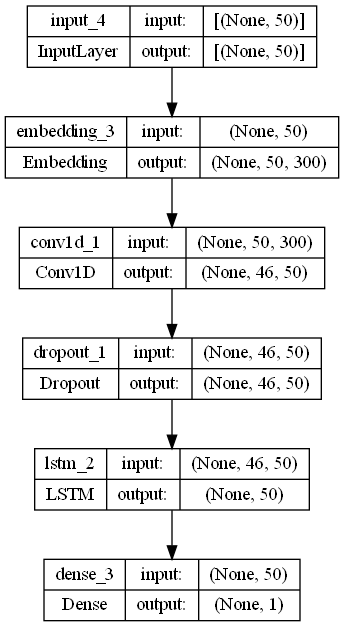

In [73]:
#to plot the model
tf.keras.utils.plot_model(model, "cnn_lstm_w2v.png", show_shapes=True)

In [74]:
reg_history = model.fit(x_train, y_train, validation_split=0.1,epochs=10, batch_size=128, callbacks =[earlystopping], verbose=1)

Epoch 1/10
1173/1173 [==============================] - 310s 258ms/step - loss: 0.2701 - acc: 0.8895 - val_loss: 0.2181 - val_acc: 0.9162
Epoch 2/10
1173/1173 [==============================] - 297s 254ms/step - loss: 0.1687 - acc: 0.9359 - val_loss: 0.1884 - val_acc: 0.9317
Epoch 3/10
1173/1173 [==============================] - 291s 248ms/step - loss: 0.1143 - acc: 0.9586 - val_loss: 0.1968 - val_acc: 0.9334
Epoch 4/10
1173/1173 [==============================] - 290s 248ms/step - loss: 0.0859 - acc: 0.9686 - val_loss: 0.2193 - val_acc: 0.9333
Epoch 5/10
1173/1173 [==============================] - 296s 253ms/step - loss: 0.0678 - acc: 0.9756 - val_loss: 0.2342 - val_acc: 0.9375
Epoch 5: early stopping


In [75]:
#saving the model
model.save('cnn_lstm_w2v')

INFO:tensorflow:Assets written to: cnn_lstm_w2v\assets


INFO:tensorflow:Assets written to: cnn_lstm_w2v\assets


In [76]:
# Loading the model from saved location
model = keras.models.load_model('cnn_lstm_w2v')

In [77]:
output_test = model.predict(x_test)
print("test auc:", roc_auc_score(y_test,output_test[:]))

1303/1303 [==============================] - 15s 11ms/step
test auc: 0.9749109595440478


In [78]:
test_scores = model.evaluate(x_test, y_test, verbose=1)
print("\nTest loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

1303/1303 [==============================] - 15s 11ms/step - loss: 0.1992 - acc: 0.9274

Test loss: 0.1992262750864029
Test accuracy: 0.9274110198020935


In [79]:
print("Train accuracy is :",reg_history.history['acc'][-1])
print("Train loss is :",reg_history.history['loss'][-1])
print("validation accuracy is :",reg_history.history['val_acc'][-1])
print("Validation loss  is :",reg_history.history['val_loss'][-1])

Train accuracy is : 0.9755564332008362
Train loss is : 0.0677701085805893
validation accuracy is : 0.9375487565994263
Validation loss  is : 0.23415765166282654


In [80]:
# Confusion Matrix for test
p_test = [1 if i>.5 else 0 for i in output_test[:]]
cm_test = confusion_matrix(y_test,p_test)
cm_test

array([[16444,  1258],
       [ 1767, 22204]], dtype=int64)

Text(33.0, 0.5, 'Actual')

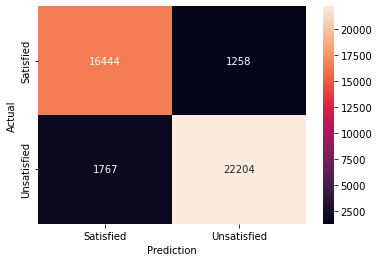

In [81]:
# Visualising Confusion matrix using heatmap form seaborn
ax = sns.heatmap(cm_test,annot=True,xticklabels=['Satisfied','Unsatisfied'],yticklabels=['Satisfied','Unsatisfied'],fmt='g')
ax.set_xlabel('Prediction')
ax.set_ylabel('Actual')

In [82]:
p_test = [1 if i>.5 else 0 for i in output_test[:]]
print("Test F1 score is : ", f1_score(y_test,p_test))

Test F1 score is :  0.9362258343347457


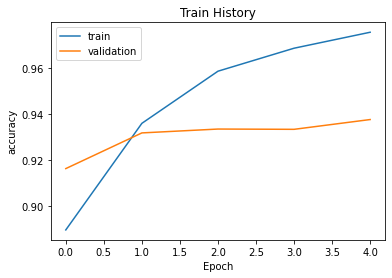

In [84]:
plt.plot(reg_history.history['acc'])
plt.plot(reg_history.history['val_acc'])
plt.title('Train History')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Predict whether a user is Satisfied or Not based on the User inputed review

In [85]:
model = keras.models.load_model('cnn_lstm_w2v')

In [98]:
review = input("Enter the review : ")

Enter the review : good product.. cheap


In [99]:
def predict_emotion(review):
    sequence = tokenizer.texts_to_sequences([review])
    padded_sequence = pad_sequences(sequence, maxlen=50)
    output = model.predict(padded_sequence,verbose=0)
    if (output[0][0] > 0.5):
        return 0
    else :
        return 1

In [100]:
if (predict_emotion(review)):
    print("Customer is not satisfied")
else:
    print("Customer is satisfied")

Customer is satisfied


# Comparison between models

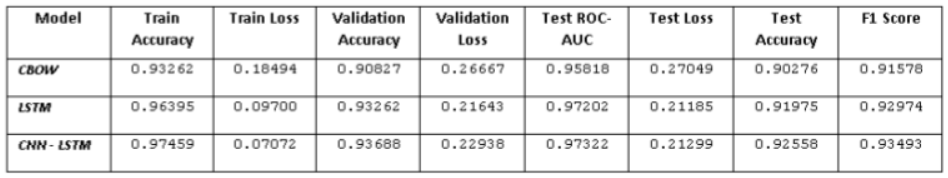

# Conclusion

Using CNN-LSTM model is the best approach to do sentiment anaysis.

### Performance of CNN-LSTM:
    Train accuracy is : 0.9755564332008362
    Train loss is : 0.0677701085805893
    validation accuracy is : 0.9375487565994263
    Validation loss  is : 0.23415765166282654
    test auc: 0.9749109595440478
    Test loss: 0.1992262750864029
    Test accuracy: 0.9274110198020935
    Test F1 score is :  0.9362258343347457

## Repository

https://www.kaggle.com/code/eliotbarr/text-classification-using-neural-networks/data?select=GrammarandProductReviews.csv

## References

i) Samira Zad, Maryam Heidari, James H Jr Jones, Ozlem Uzuner, "Emotion Detection of Textual Data: An Interdisciplinary Survey" 978-1-6654-3568-0/21/31.00©2021 IEEE 0255
 
ii) Sepideh Saeedi Majd, Habiblzadkhah, Shahriar Lotfi, "Detectionof Multiple Emotionsin Texts Using LongShort-Term Memory Recurrent Neural Networks" 978 -1-6654-6626-4/22/ 31.00 ©2022 IEEE.

iii) https://www.kaggle.com/code/eliotbarr/text-classification-using-neural-networks 

iv) https://anandsarank.medium.com/cnn-with-Istm-for-text-classification-53d18e5f7f5c
